# Autoencoder with CNN and LSTM layers  

Extension of the 475 project that attempts to add LSTM layers after CNN  
Works on a custom dataset that has packet captures from documented Malware and Benign applications  
Trains on sequences of packets, validates using the labels  

### Dataloading and encoding

In [1]:
import hashlib
import torch
import numpy as np
import pandas as pd

from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

dataset_path = 'C:/Users/theob/Code/Supervised Malware Detection/Dataset/USTC-TFC2016-master/1_mil_final.csv'
df = pd.read_csv(dataset_path)
df.fillna(0, inplace=True)

def one_hot_encode_protocol(df, column_name='protocol'):
    """One-hot encode the protocol column of a pandas DataFrame."""
    one_hot = pd.get_dummies(df[column_name], prefix=column_name, dtype=float)
    return pd.concat([df.drop(column_name, axis=1), one_hot], axis=1)

def hash_ip(ip_address):
    """Hash an IP address into a fixed-size integer."""
    # Use SHA-256 hashing
    hashed_ip = hashlib.sha256(ip_address.encode('utf-8')).hexdigest()
    # Convert the hash to an integer
    numeric_ip = int(hashed_ip, 16) % (10 ** 10)  # Use modulo to keep integer size manageable
    return numeric_ip

df['src_ip'] = df['src_ip'].astype(str) 
df['dst_ip'] = df['dst_ip'].astype(str)
df['src_ip'] = df['src_ip'].apply(hash_ip)
df['dst_ip'] = df['dst_ip'].apply(hash_ip)

# One-hot encode protocol
df = one_hot_encode_protocol(df)

print(df.keys())

Index(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'timing', 'label',
       'protocol_0', 'protocol_TCP', 'protocol_UDP'],
      dtype='object')


### Sequence Creation

In [2]:
df.sort_values(by='timing', inplace=True)

# Function to create sequences from the DataFrame
def create_sequences(df, sequence_length=32):
    """
    Organize the DataFrame by time and create sequences of packets with the same label.

    Parameters:
    - df: DataFrame, the preprocessed DataFrame.
    - sequence_length: int, the length of each sequence.

    Returns:
    - sequences: List of np.arrays, the packet sequences.
    - sequence_labels: List of int, the labels for each sequence.
    """
    sequences = []
    sequence_labels = []
    
    # Step 2 & 3: Filter by Label and Create Sequences
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        
        # Split the dataframe into chunks of size `sequence_length`
        num_sequences = len(label_df) // sequence_length
        for i in range(num_sequences):
            sequence = label_df.iloc[i*sequence_length : (i+1)*sequence_length]
            sequences.append(sequence.drop(['label'], axis=1).to_numpy())
            sequence_labels.append(label)
    
    return sequences, sequence_labels

# Apply the function to create sequences
sequences, sequence_labels = create_sequences(df)

### Scaling the sequences

In [3]:
def scale_sequences(sequences):
    """
    Scale the sequences to have a Gaussian distribution with a mean of 0 and a std of 1.

    Parameters:
    - sequences: List of np.arrays, the packet sequences.

    Returns:
    - scaled_sequences: List of np.arrays, the scaled packet sequences.
    """
    # Initialize the StandardScaler
    scaler = MinMaxScaler()
    
    # Reshape the sequences for scaling: Convert list of 2D arrays into a 2D array
    sequences_shape = sequences[0].shape # Shape of a single sequence (16, num_features)
    sequences_concatenated = np.concatenate(sequences, axis=0)
    
    # Fit and transform the data
    scaled_data = scaler.fit_transform(sequences_concatenated)
    
    # Reshape back into the original list of 2D arrays
    scaled_sequences = [scaled_data[i*sequences_shape[0]:(i+1)*sequences_shape[0]] for i in range(len(sequences))]
    
    return scaled_sequences

# Apply the scaling function to your sequences
scaled_sequences = scale_sequences(sequences)

### Converting the sequences to tensors

In [4]:
def sequences_to_tensors(sequences, sequence_labels):
    """
    Convert sequences and their labels into PyTorch tensors efficiently.

    Parameters:
    - sequences: List of np.arrays, the packet sequences.
    - sequence_labels: List of int, the binary labels for each sequence.

    Returns:
    - sequence_tensors: PyTorch Tensor, the packet sequences as tensors.
    - label_tensors: PyTorch Tensor, the labels for each sequence as tensors.
    """
    # Stack the sequences into a single numpy array
    sequences_array = np.stack(sequences)
    
    # Convert the stacked array to a PyTorch tensor
    sequence_tensors = torch.tensor(sequences_array, dtype=torch.float32)
    
    # Convert labels to a tensor
    label_tensors = torch.tensor(sequence_labels, dtype=torch.long)
    
    return sequence_tensors, label_tensors

def binarize_labels(sequence_labels):
    """
    Convert sequence labels from categorical ('Benign', 'Malware') to binary (0, 1).

    Parameters:
    - sequence_labels: List of str, the categorical labels for each sequence.

    Returns:
    - binary_labels: List of int, the binary labels for each sequence.
    """
    binary_labels = [0 if label == 'Benign' else 1 for label in sequence_labels]
    return binary_labels

# Assuming `sequence_labels` contains your categorical labels
binary_sequence_labels = binarize_labels(sequence_labels)

# Now convert your sequences and the newly binarized labels into PyTorch tensors
sequence_tensors, label_tensors = sequences_to_tensors(scaled_sequences, binary_sequence_labels)

### Create train and test datasets and instantiate DataLoader objects

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        sequences: A tensor of shape [n_sequences, 16, 7] - packets per sequence and features per packet
        labels: A tensor of labels for the sequences
        """
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Optionally, add any sequence-specific preprocessing here
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

# 1. Splitting dataset into class-specific subsets
sequences_0 = sequence_tensors[label_tensors == 0]
labels_0 = label_tensors[label_tensors == 0]

sequences_1 = sequence_tensors[label_tensors == 1]
labels_1 = label_tensors[label_tensors == 1]

# 2. Ensuring even class distribution for the validation set (similarly to the test set)
min_count = min(len(sequences_0), len(sequences_1))
# Using a portion of data for validation, let's say 20% of min_count
val_count = int(0.2 * min_count)

# 3. Randomly sampling for validation set
perm_0_val = torch.randperm(len(sequences_0))[:val_count]
perm_1_val = torch.randperm(len(sequences_1))[:val_count]

# Creating balanced validation datasets
sequences_val_balanced = torch.cat((sequences_0[perm_0_val], sequences_1[perm_1_val]), dim=0)
labels_val_balanced = torch.cat((labels_0[perm_0_val], labels_1[perm_1_val]), dim=0)

# 4. Updating train dataset after excluding validation samples
sequences_0_train = torch.cat((sequences_0[val_count:], sequences_0[:val_count]), dim=0)[val_count:]
labels_0_train = torch.cat((labels_0[val_count:], labels_0[:val_count]), dim=0)[val_count:]

sequences_1_train = torch.cat((sequences_1[val_count:], sequences_1[:val_count]), dim=0)[val_count:]
labels_1_train = torch.cat((labels_1[val_count:], labels_1[:val_count]), dim=0)[val_count:]

# 5. Creating train, validation, and test datasets & loaders
train_dataset = SequenceDataset(torch.cat((sequences_0_train, sequences_1_train), dim=0), torch.cat((labels_0_train, labels_1_train), dim=0))
val_dataset = SequenceDataset(sequences_val_balanced, labels_val_balanced)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f'Shape of training data: {len(train_dataset)} {len(train_dataset[0])}')
print(f'Shape of testing data: {len(val_dataset)} {len(val_dataset[0])}')

Shape of training data: 17397 2
Shape of testing data: 3950 2


### Define our model

In [6]:
class SequenceAutoencoder(nn.Module):
    def __init__(self):
        super(SequenceAutoencoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=8, kernel_size=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),  # Intelligent pooling
            nn.Dropout(p=0.25)
        )
        self.encoder_lstm = nn.LSTM(input_size=8, hidden_size=8, batch_first=True)
        
        self.decoder_lstm = nn.LSTM(input_size=8, hidden_size=8, batch_first=True)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=8, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.Dropout(p=0.5)
        )
    
    def forward(self, x):
        x = self.encoder_conv(x)
        
        x = x.permute(0, 2, 1)  # Adjusting for LSTM input
        
        # Assuming you're dealing with LSTM layers here...
        x, (hn, cn) = self.encoder_lstm(x)
        
        x = self.decoder_conv(x.permute(0, 2, 1))  # Adjusting back for ConvTranspose1D
        
        return x


model = SequenceAutoencoder()


optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay
criterion = nn.MSELoss()

c:\Users\theob\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train the model

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=500, scheduler=None, patience=5):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0  # Initialize patience counter
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0
        
        for sequences, _ in train_loader:
            sequences = sequences.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, sequences)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation
            for sequences, _ in val_loader:
                sequences = sequences.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, sequences)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Checkpoint and early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model checkpoint saved')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
        
        if patience_counter > patience:
            print(f'Stopping early at epoch {epoch+1}. No improvement in validation loss for {patience} epochs.')
            break
        
        # Update learning rate
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)  # For ReduceLROnPlateau
            else:
                scheduler.step()  # For other types of schedulers
    
    print('Training complete')


# Configuration and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SequenceAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * 15
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=500, scheduler=scheduler)


Epoch 1/500, Training Loss: 0.2192, Validation Loss: 0.1416
Model checkpoint saved
Epoch 2/500, Training Loss: 0.1845, Validation Loss: 0.1313
Model checkpoint saved
Epoch 3/500, Training Loss: 0.1811, Validation Loss: 0.1300
Model checkpoint saved
Epoch 4/500, Training Loss: 0.1802, Validation Loss: 0.1297
Model checkpoint saved
Epoch 5/500, Training Loss: 0.1797, Validation Loss: 0.1250
Model checkpoint saved
Epoch 6/500, Training Loss: 0.1791, Validation Loss: 0.1305
Epoch 7/500, Training Loss: 0.1792, Validation Loss: 0.1283
Epoch 8/500, Training Loss: 0.1790, Validation Loss: 0.1297
Epoch 9/500, Training Loss: 0.1789, Validation Loss: 0.1301
Epoch 10/500, Training Loss: 0.1790, Validation Loss: 0.1281
Epoch 11/500, Training Loss: 0.1786, Validation Loss: 0.1295
Stopping early at epoch 11. No improvement in validation loss for 5 epochs.
Training complete


### Evaluate

In [16]:
def predict_anomaly(model, data_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    reconstruction_errors = []
    predictions = []

    with torch.no_grad():  # No gradients needed
        for sequences, _ in data_loader:
            sequences = sequences.to(device)
            reconstructed = model(sequences)
            error = torch.mean((sequences - reconstructed) ** 2, dim=[1, 2])  # Calculate MSE for each sequence
            reconstruction_errors.extend(error.tolist())

    threshold = 0.1168
    predictions = [1 if error > threshold else 0 for error in reconstruction_errors]  # 1 for anomaly, 0 for normal
    return predictions, reconstruction_errors, threshold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the right device
predictions, reconstruction_errors, threshold = predict_anomaly(model, val_loader, device)

actual_labels = labels_val_balanced.cpu().numpy()

# Evaluation metrics
print(classification_report(actual_labels, predictions, target_names=['Normal', 'Anomalous']))
print("Confusion Matrix:\n", confusion_matrix(actual_labels, predictions))

              precision    recall  f1-score   support

      Normal       0.84      0.75      0.79      1975
   Anomalous       0.77      0.86      0.81      1975

    accuracy                           0.80      3950
   macro avg       0.81      0.80      0.80      3950
weighted avg       0.81      0.80      0.80      3950

Confusion Matrix:
 [[1480  495]
 [ 284 1691]]


### Reconstruction Errors

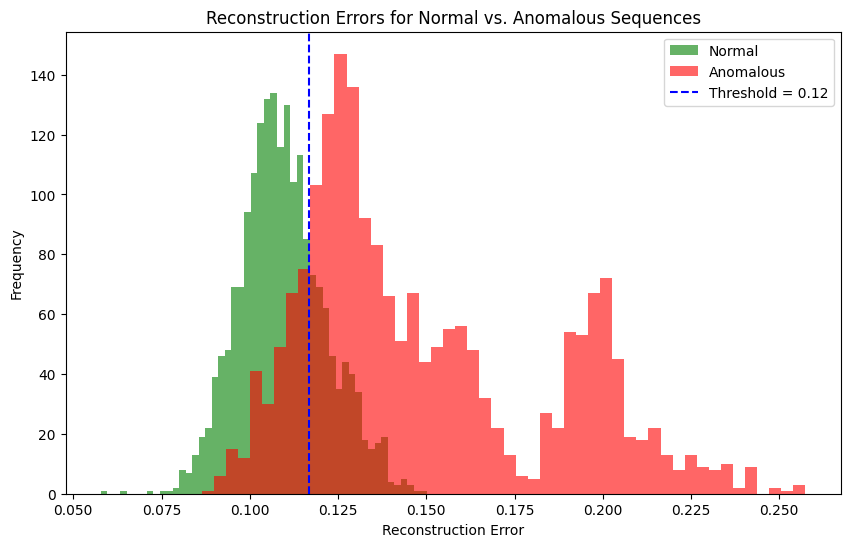

In [17]:
# Ensure reconstruction_errors is a NumPy array for easier indexing
reconstruction_errors = np.array(reconstruction_errors)

# Convert actual labels and predictions to NumPy arrays for easier handling
actual_labels = np.array(actual_labels)
predictions = np.array(predictions)

# Errors for normal and anomalous sequences
errors_normal = reconstruction_errors[actual_labels == 0]
errors_anomalous = reconstruction_errors[actual_labels == 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(errors_normal, bins=50, color='green', alpha=0.6, label='Normal')
plt.hist(errors_anomalous, bins=50, color='red', alpha=0.6, label='Anomalous')

# Threshold line
plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.2f}')

plt.title('Reconstruction Errors for Normal vs. Anomalous Sequences')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Principle Component Analysis (PCA)

Explained variance by 2 components: 0.98


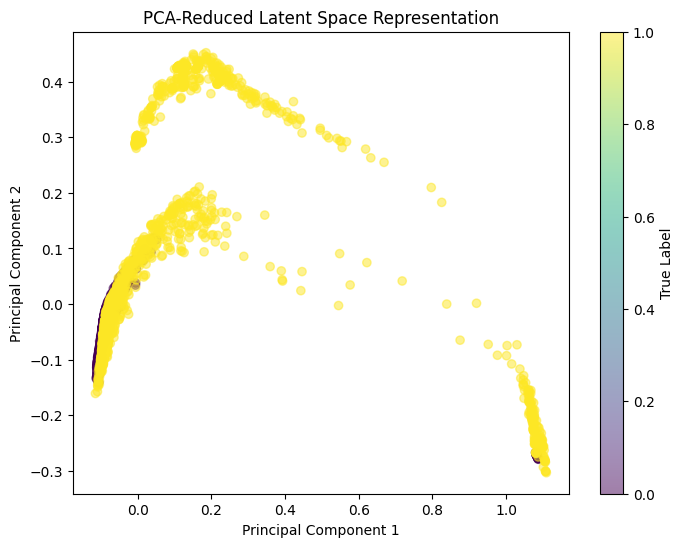

Number of PCA components: 2
Number of features in PCA: 8
Number of feature names provided: 8
Top contributing features for PC1:
protocol_UDP: 0.9036
src_port: -0.4017

Top contributing features for PC2:
timing: -0.8620
src_port: 0.3869



In [10]:
def extract_latent_features(model, data_loader, device):
    model.eval()
    latent_features = []
    
    with torch.no_grad():
        for sequences, _ in data_loader:
            sequences = sequences.to(device)
            
            # Pass through the encoder
            x = model.encoder_conv(sequences)
            x = x.permute(0, 2, 1)  # Adjust for LSTM input
            _, (hn, _) = model.encoder_lstm(x)  # hn is the last hidden state
            
            # For an LSTM, hn shape is (num_layers * num_directions, batch, hidden_size)
            # We take the last layer's hidden state for each sequence
            latent_features.append(hn[-1].detach().cpu().numpy())

    # Concatenate all batches
    return np.concatenate(latent_features, axis=0)

def print_pca_components_loadings(pca_model, n_features, feature_names):
    components = pca_model.components_
    num_components, num_features = components.shape

    # Ensure the requested number of top features does not exceed the actual number
    n_features = min(n_features, num_features)

    for i in range(min(num_components, 2)):  # Assuming we only want to look at the first 2 PCs
        print(f"Top contributing features for PC{i+1}:")
        top_features_idx = np.argsort(np.abs(components[i]))[::-1][:n_features]
        for feature_idx in top_features_idx:
            if feature_idx < len(feature_names):  # Check if the index is within bounds
                print(f"{feature_names[feature_idx]}: {components[i][feature_idx]:.4f}")
            else:
                print(f"Feature index {feature_idx} out of bounds.")
        print()

latent_features = extract_latent_features(model, val_loader, device)
feature_names = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'timing',
       'protocol_0', 'protocol_TCP', 'protocol_UDP']

# Assuming latent_features is obtained from the modified extract_latent_features_for_sequences function
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_features)

print(f"Explained variance by 2 components: {np.sum(pca.explained_variance_ratio_):.2f}")

actual_labels = labels_val_balanced.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=actual_labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='True Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Latent Space Representation')
plt.show()

print(f"Number of PCA components: {pca.components_.shape[0]}")
print(f"Number of features in PCA: {pca.components_.shape[1]}")
print(f"Number of feature names provided: {len(feature_names)}")

print_pca_components_loadings(pca, 2, feature_names)